In [107]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

For the coding logical, it will follow this information:
-              Forest agent:

o   There are 4 states represent for 4 agents in the forest: 0 for no tree, 1 for tree, 2 for fire and 3 for fire fighter – the action of this will be from the fire fighter agent. The state will be updated in each time step.

o   Creat_fire_fighters: to put 4 fighters at 4 corners of the forest

o   Create_fire: to select randomly one tree to put the fire on the forest

o   Ignite_tree: to track the lifetime of the fire and select randomly one tree to burn. If the fire “aged”, then the fire will be removed from the forest to mark that the tree is fully burned. As in the research paper, the authors did not mention how the fire will spread, so it is assumed in this case that the fire will burn only one more tree in the next time step

o   Step: to be called to repeat the rules each time step

-              Fire_fighter agent:

o   Extinguish_fire: will be called every timestep. If there is at least one fire surrounding the fighters, they will move towards randomly one fire to extinguish it. Otherwise, the fighter just moves. As the number of steps was not mentioned in the research, then it is assumed that the fighter will move randomly one of 8 cell surrounding them.

o   Check: to check the surrounding areas of the fighter.  As the vision attribute of the fighter was not mentioned in the research, then it is assumed that the fighter can check surrounding 8 cell.

o   Move: to move the fire fighter randomly. Since the way the fighter moves was not discussed in the authors’ research paper, then the fighter is assumed to move randomly to 1 of 8 cells surrounding them

For the first model, it follows this rule:     
1. On forest, one random fire spread to a tree if there are trees surrounding it. The age of the fire is counted.

2.        If a fire reaches its maximum burning time, then the fire and the tree will be removed, and the state will be no tree

3.        Each fire fighter checks around to find the fire.

4.        After checking, if any tree has fire, the fire fighter moves towards it to extinguish the fire. If there is no fire, then the fire fighter moves randomly to one location surrounding them.

5.        Update the forest states and fire fighter locations.

6.        Repeat the process

In [108]:
import numpy as np
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [109]:
class Forest(Cell2D):
    """Represents a grid of forest and fire agent."""

    options = dict(mode='same', boundary='wrap') #Same size, the neighbors are wrapped around the edges (cell)

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8) #mention the 3*3 array, with 8 neighbors and center is the current cell which will not be counted

    def __init__(self, n, p, fire_life_time):
        """Initializes the forest attributes.
        n: number of rows -- size of the environment
        p: threshold on the fraction of empty and trees coverage area
        fire_life_time: The life time of the fire
        """
        # Forest area
        self.forest_area = n*n # the map (area) of the fire
        self.fire_life_time=fire_life_time # the life time of the fire

        self.fire_current_life = np.zeros((n,n), dtype=np.int8) # The array to store the age of the fire

        # A list of fire fighters
        self.fire_fighters=[] # the list to store the fire fighters

        # 0 is neither no tree and fire, 1 is agent labelled as tree, 2 is agent labelled with fire
        states = np.array([0, 1], dtype=np.int8) # The array of 2 values 0 and 1
        probability = [1-p, p] # The probability of tree coverage

        self.kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8) #mention the 3*3 array, with 8 neighbors and center is the current cell which will not be counted

        # randomly initialize a forest grid with size n*n, occupied by two kinds of agents (empty and tree)
        # about 25% of the forest are empty.
        # in [0, 1], 25% of the forest will be empty, 75% of the forest will be filled with 1 (which means with trees).
        self.forest = np.random.choice(states, (n, n), p=probability) # Randomly create a map

        # create the fire fighters:
        self.forest, self.fire_fighters = self.create_fire_fighters(n) # Save the new forest map and create 4 fire fighters in 4 corners of the map

        #create the fire
        self.forest, self.fire = self.create_fire() # Save the new forest map and create a fire

        self.tree_replaced=0 # Save the state to swap the location of when the fire fighters move

    def create_fire_fighters(self,n):
        """Initializes the fire fighters in 4 corners of the forest. The state of the fire fighters will be 3"""
        initial_locations = [(0,0), (0,n-1), (n-1,0), (n-1,n-1)] # 4 corners of the map
        for location in initial_locations:
            self.forest[location[0],location[1]] = 3
            self.fire_fighters.append(Fire_fighter(location)) # Create the fire fighters
        return self.forest, self.fire_fighters

    def create_fire(self):
        """Initializes the a fire. The state of the fire will be 2"""
        tree_locations = np.argwhere(self.forest==1) # check where the trees' locations in the forest
        random_fire = tree_locations[np.random.choice(len(tree_locations))] # choose random one tree location which will have the fire
        self.forest[random_fire[0], random_fire[1]]=2 # change the state of the tree to 3 which means the tree is being burned
        return self.forest, random_fire

    def ignite_trees(self):
        """Change the states of one tree to being burned if there is a fire surrounding them and remove the fire if it reaches maximum life time"""
        mask = self.forest == 2 # Create the mask to check the fire locations
        self.fire_current_life[mask]+=1 # Add the life of the fire
        firing=np.argwhere(self.fire_current_life>=self.fire_life_time) # Create the mask to check the fire age
        for fire in firing:
            self.forest[fire[0], fire[1]]=0 # When the fire burned the fire
            self.fire_current_life[fire[0], fire[1]]=0 # Change the state of the fire after aged to 0

        surrounding_trees = correlate2d(mask, self.kernel, mode = 'same') #Check for the fire on the map
        being_burned = np.argwhere((self.forest==1) & (surrounding_trees > 0))
        if len(being_burned)>0: #If there are 1 tree, then that tree will be burned. If more than 2 trees, the fire will burn randomly one tree
            random_being_burned = being_burned[np.random.choice(len(being_burned))]
            self.forest[random_being_burned[0], random_being_burned[1]]=2
            self.fire_current_life[random_being_burned[0], random_being_burned[1]] = 1 #Set the age of the fire to 1

    def step(self):
        """Execute every timestep"""
        self.ignite_trees() #Create one fire
        for fire_fighter in self.fire_fighters: #Loop through each fire fighters and let them move
            fire_fighter.extinguish_fire(self.forest)
            self.tree_replaced += fire_fighter.previous_state #Change the state they stand on to the previous stage the cell was

    def fire_percentage(self):
        """Calculate the percentage of fire spread over each timestep"""
        return (np.sum(self.forest==2) / self.forest_area)*100

    def forest_percentage(self):
        """Calculate the percentage of forest coverage over each timestep"""
        forest_coverage = ((np.sum(self.forest==1) + self.tree_replaced) / self.forest_area)*100
        self.tree_replaced=0
        return forest_coverage

    def draw(self):
        """Draws the forest grid with the specified colors for each cell state"""
        cmap = ListedColormap(['white', 'green', 'red', 'blue'])  # Color map for states
        plt.imshow(self.forest, cmap=cmap, origin='lower')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        plt.show()


In [110]:
class Fire_fighter:
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8) #mention the 3*3 array, with 8 neighbors and center is the current cell which will not be counted

    def __init__(self, loc):
        self.loc=loc
        self.previous_state = 0 # Save the state to swap the location of when the fire fighters move

    def check(self, forest):
        """Check the surroundings of the fire fighter to see if there is any fire

        Return a list of the fire locations
        """
        # create the fire locations list
        fires = []
        # get the shape of the forest
        n = forest.shape[0]

        # the location of the fire fighter in the map
        x, y = self.loc

        # There are 8 possible directions the fire fighter can move. As in this case, the fire fighter can only move one cell per timestep
        ways = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]

        for loc_x, loc_y in ways:
            new_x = (x+loc_x)
            new_y = (y+loc_y)
            # Check if the location next to the fire fighter is the fire or not
            if 0 <= new_x < n and 0 <= new_y < n:
              if forest[new_x, new_y] == 2:
                  fires.append((new_x, new_y)) #location of the fire on the forest
        return fires

    def extinguish_fire(self, forest):
        """Extinguish a fire if there is at least one fire surrounding the fire fighter. Move randomly otherwise"""
        fires = self.check(forest)
        if len(fires) == 0:
            self.move(forest)
        else:
            #select randomly a fire to move toward
            fire_loc = fires[np.random.choice(len(fires))]
            x, y = self.loc
            #bring back the state of the cell where the fire fighter was on
            forest[x,y] = self.previous_state
            #save the fire fighter new location as the fire location
            self.loc = fire_loc
            # The fire location will be occupied by the fire fighter, so the state will be changed
            forest[fire_loc]=3
            # When the fire fighter move away from the fire, the cell will be empty
            self.previous_state = 0

    def move(self, forest):
        """Move the fire fighter"""
        n = forest.shape[0]
        # the location of the fire fighter in the map
        x, y = self.loc
        # There are 8 possible directions the fire fighter can move. As in this case, the fire fighter can only move one cell per timestep
        ways = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        # Shuffle directions to add randomness
        np.random.shuffle(ways)
        # Attempt to move in one randomly chosen valid direction
        for new_loc_x, new_loc_y in ways:
            new_x = x+new_loc_x
            new_y = y+new_loc_y
            if 0<=new_x<n and 0<=new_y<n:
                if forest[new_x, new_y] in (0,1):
                    #save the state of the cell before changing
                    new_cell_state = forest[new_x, new_y]
                    #set the previous location of the fire fighter to the previous state of that location (either empty or a tree)
                    forest[x,y] = self.previous_state
                    #set the new location the fire fighter move to to fire fighter
                    forest[new_x, new_y]=3
                    #save the state of the cell that the fire fighter move to to the previous state, so either empty or tree locations will be saved
                    self.previous_state = new_cell_state
                    self.loc = (new_x, new_y)
                    return
        # If no valid move, do nothing
        forest[x, y] = 3


We will check the first initial forest

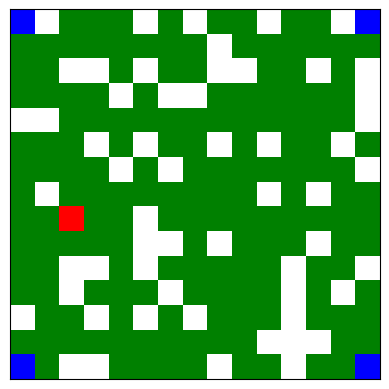

Fire Percentage: 0.4444444444444444
Forest Coverage: 72.44444444444444
Time step: 0


In [111]:
np.random.seed(17)
example = Forest(15, 0.75, 20)
example.draw()
print("Fire Percentage: " + str(example.fire_percentage()))
print("Forest Coverage: " + str(example.forest_percentage()))
print("Time step: "+str(0))

We will loop through 50 time steps

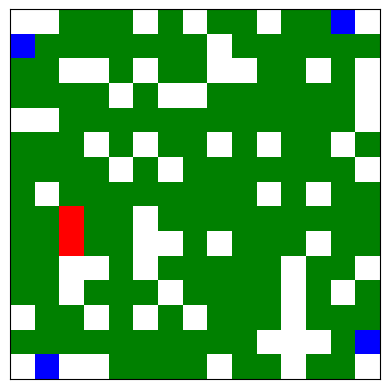

Fire Percentage: 0.8888888888888888
Forest Coverage: 72.0
Time step: 1


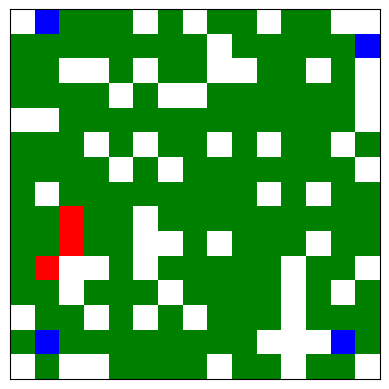

Fire Percentage: 1.3333333333333335
Forest Coverage: 71.55555555555554
Time step: 2


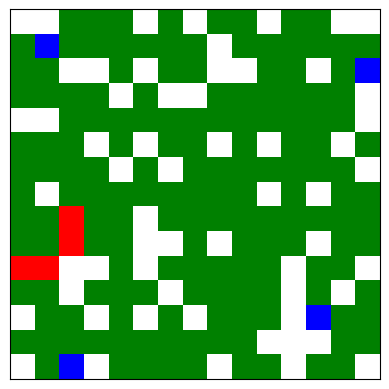

Fire Percentage: 1.7777777777777777
Forest Coverage: 71.11111111111111
Time step: 3


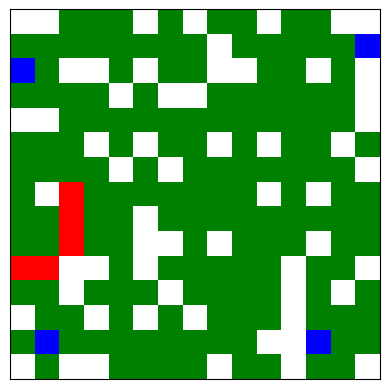

Fire Percentage: 2.2222222222222223
Forest Coverage: 70.66666666666667
Time step: 4


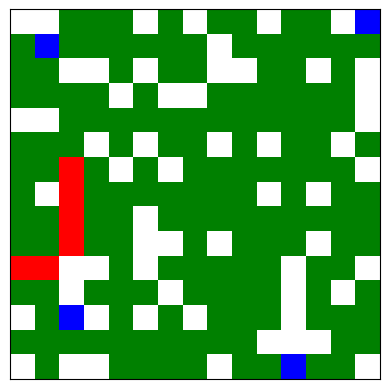

Fire Percentage: 2.666666666666667
Forest Coverage: 70.22222222222221
Time step: 5


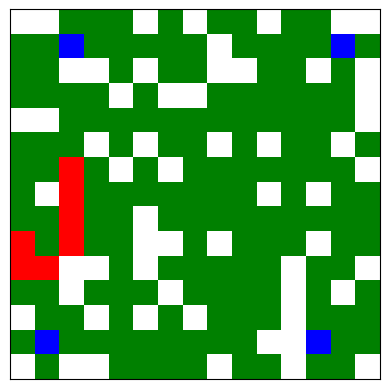

Fire Percentage: 3.111111111111111
Forest Coverage: 69.77777777777779
Time step: 6


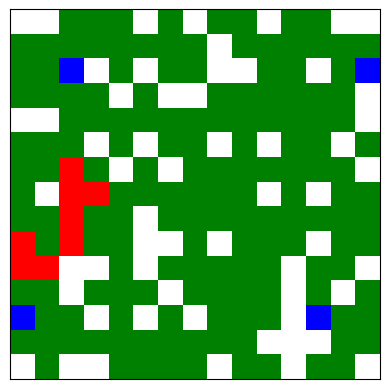

Fire Percentage: 3.5555555555555554
Forest Coverage: 69.33333333333334
Time step: 7


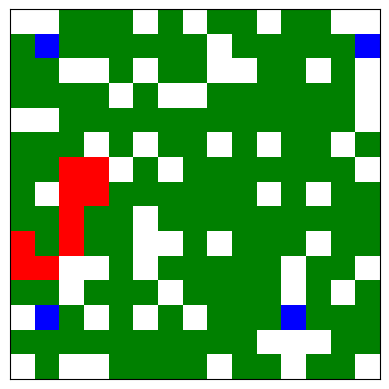

Fire Percentage: 4.0
Forest Coverage: 68.88888888888889
Time step: 8


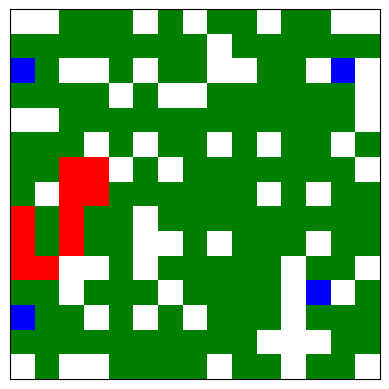

Fire Percentage: 4.444444444444445
Forest Coverage: 68.44444444444444
Time step: 9


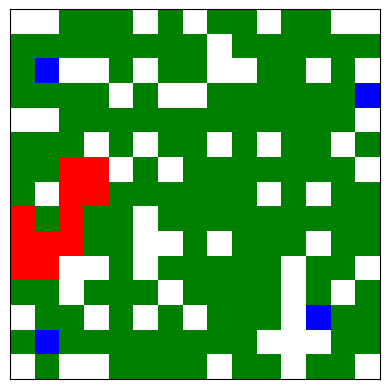

Fire Percentage: 4.888888888888889
Forest Coverage: 68.0
Time step: 10


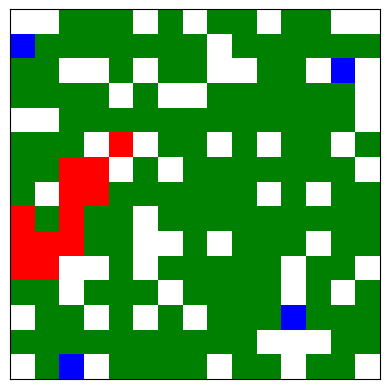

Fire Percentage: 5.333333333333334
Forest Coverage: 67.55555555555556
Time step: 11


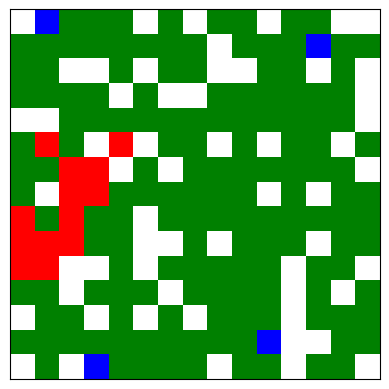

Fire Percentage: 5.777777777777778
Forest Coverage: 67.11111111111111
Time step: 12


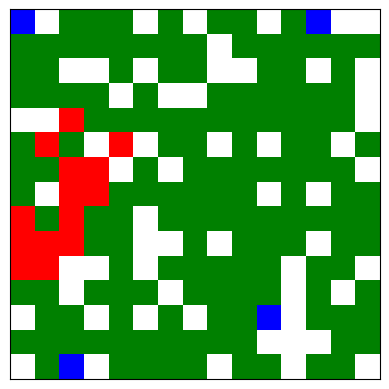

Fire Percentage: 6.222222222222222
Forest Coverage: 66.66666666666666
Time step: 13


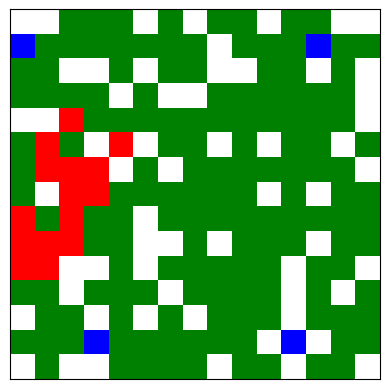

Fire Percentage: 6.666666666666667
Forest Coverage: 66.22222222222223
Time step: 14


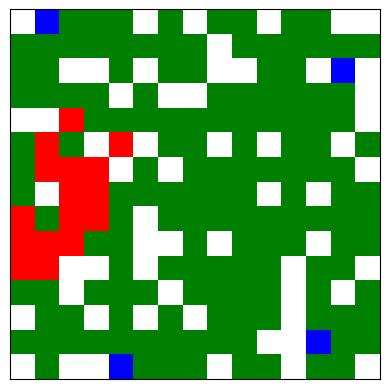

Fire Percentage: 7.111111111111111
Forest Coverage: 65.77777777777779
Time step: 15


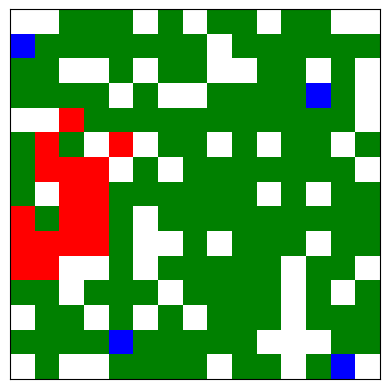

Fire Percentage: 7.555555555555555
Forest Coverage: 65.33333333333333
Time step: 16


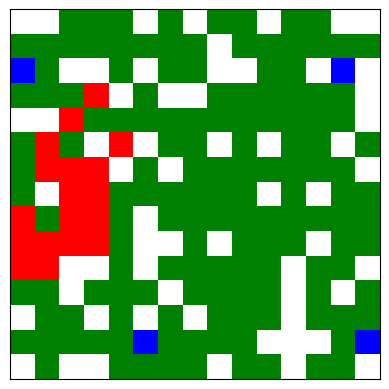

Fire Percentage: 8.0
Forest Coverage: 64.88888888888889
Time step: 17


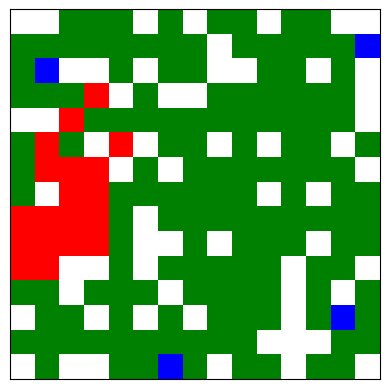

Fire Percentage: 8.444444444444445
Forest Coverage: 64.44444444444444
Time step: 18


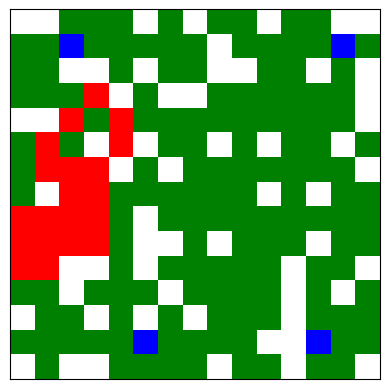

Fire Percentage: 8.88888888888889
Forest Coverage: 64.0
Time step: 19


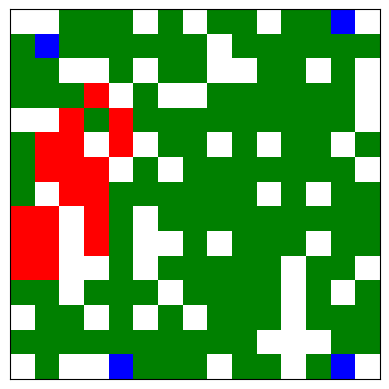

Fire Percentage: 8.444444444444445
Forest Coverage: 63.55555555555556
Time step: 20


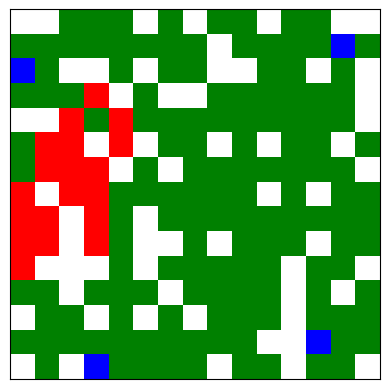

Fire Percentage: 8.444444444444445
Forest Coverage: 63.11111111111111
Time step: 21


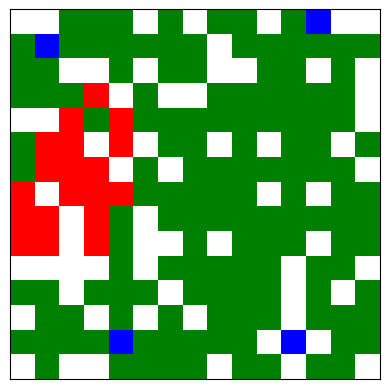

Fire Percentage: 8.444444444444445
Forest Coverage: 62.66666666666667
Time step: 22


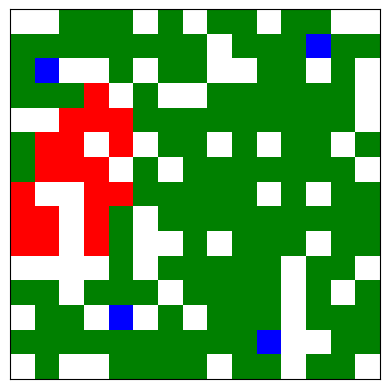

Fire Percentage: 8.444444444444445
Forest Coverage: 62.22222222222222
Time step: 23


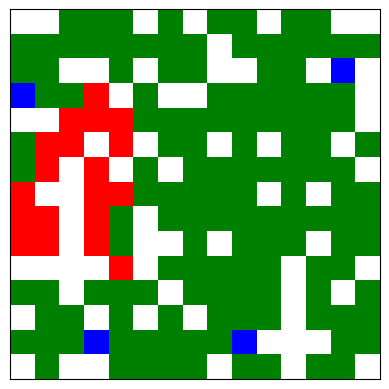

Fire Percentage: 8.444444444444445
Forest Coverage: 61.77777777777778
Time step: 24


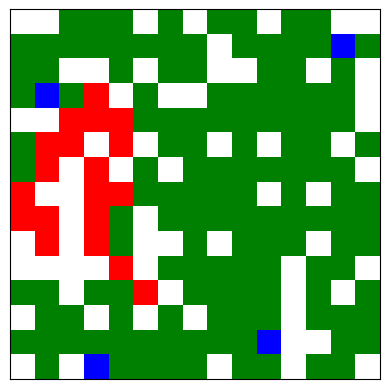

Fire Percentage: 8.444444444444445
Forest Coverage: 61.33333333333333
Time step: 25


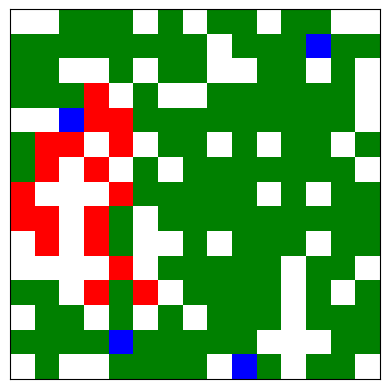

Fire Percentage: 8.0
Forest Coverage: 60.88888888888889
Time step: 26


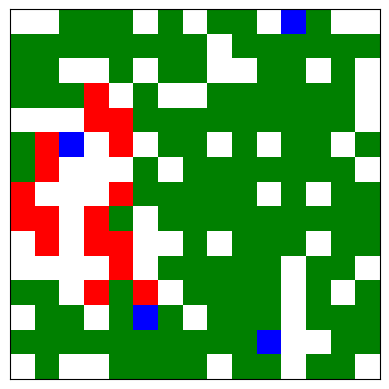

Fire Percentage: 7.555555555555555
Forest Coverage: 60.44444444444444
Time step: 27


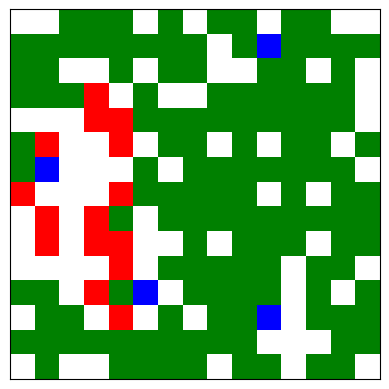

Fire Percentage: 6.666666666666667
Forest Coverage: 60.0
Time step: 28


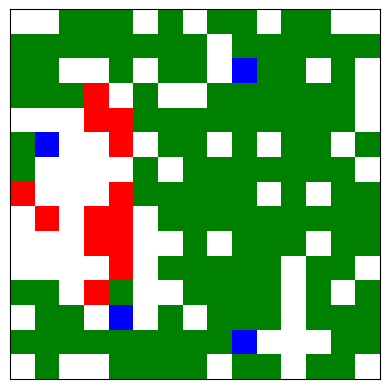

Fire Percentage: 5.777777777777778
Forest Coverage: 59.55555555555555
Time step: 29


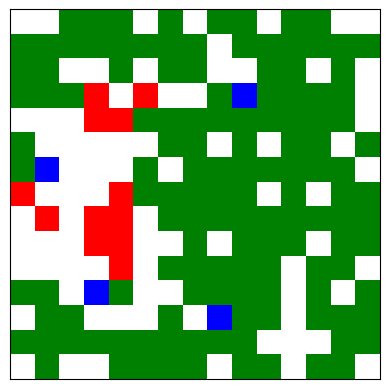

Fire Percentage: 5.333333333333334
Forest Coverage: 59.111111111111114
Time step: 30


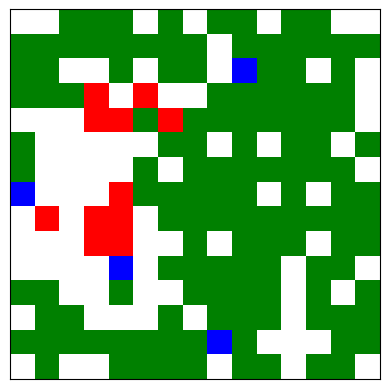

Fire Percentage: 4.888888888888889
Forest Coverage: 58.666666666666664
Time step: 31


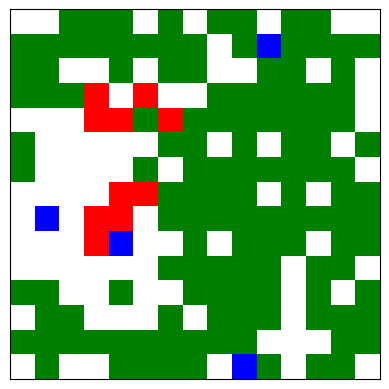

Fire Percentage: 4.444444444444445
Forest Coverage: 58.22222222222222
Time step: 32


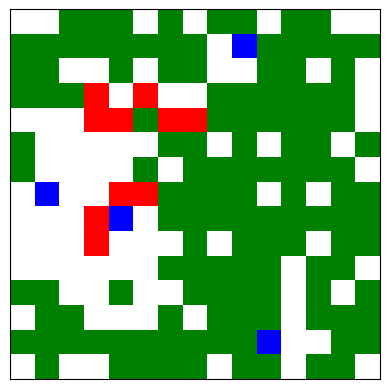

Fire Percentage: 4.444444444444445
Forest Coverage: 57.77777777777777
Time step: 33


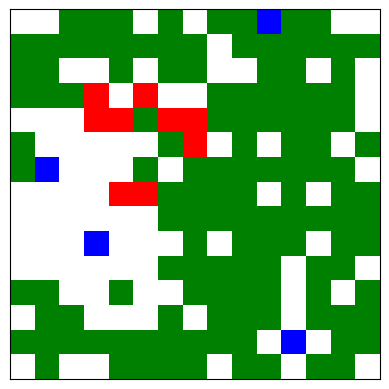

Fire Percentage: 4.0
Forest Coverage: 57.333333333333336
Time step: 34


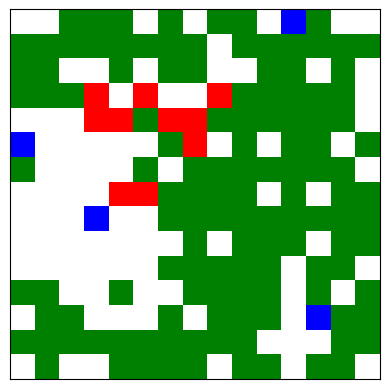

Fire Percentage: 4.444444444444445
Forest Coverage: 56.888888888888886
Time step: 35


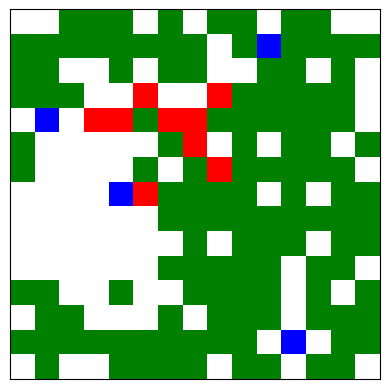

Fire Percentage: 4.0
Forest Coverage: 56.44444444444444
Time step: 36


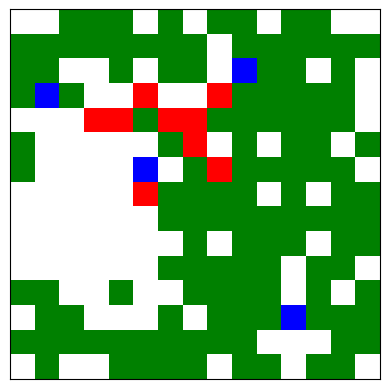

Fire Percentage: 4.0
Forest Coverage: 56.00000000000001
Time step: 37


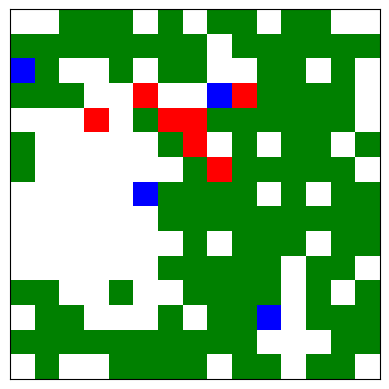

Fire Percentage: 3.111111111111111
Forest Coverage: 55.55555555555556
Time step: 38


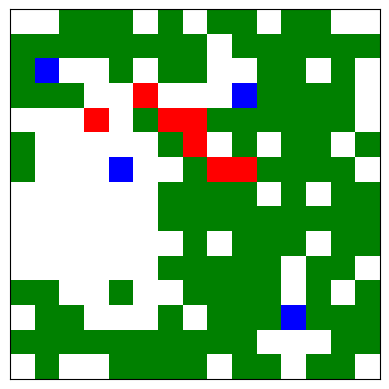

Fire Percentage: 3.111111111111111
Forest Coverage: 55.111111111111114
Time step: 39


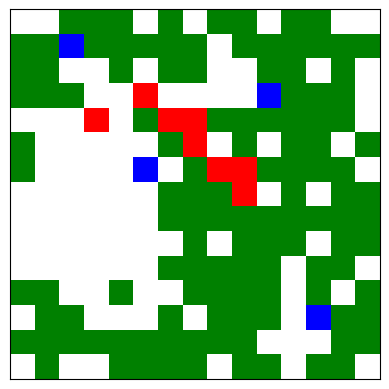

Fire Percentage: 3.5555555555555554
Forest Coverage: 54.666666666666664
Time step: 40


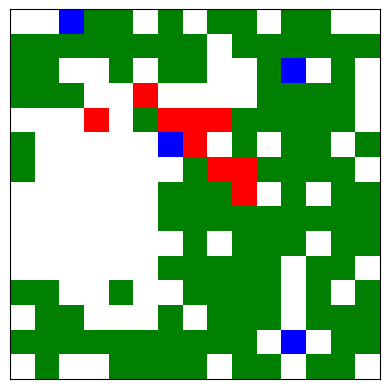

Fire Percentage: 4.0
Forest Coverage: 54.22222222222223
Time step: 41


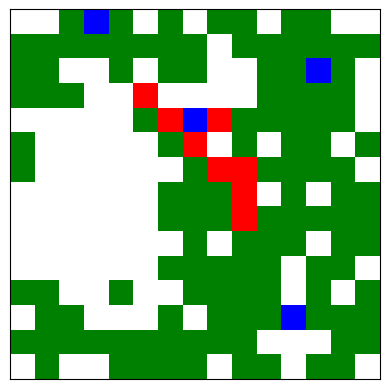

Fire Percentage: 3.5555555555555554
Forest Coverage: 53.77777777777778
Time step: 42


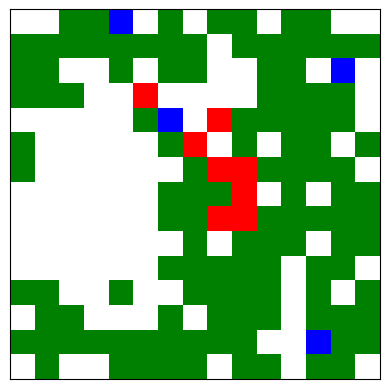

Fire Percentage: 3.5555555555555554
Forest Coverage: 53.333333333333336
Time step: 43


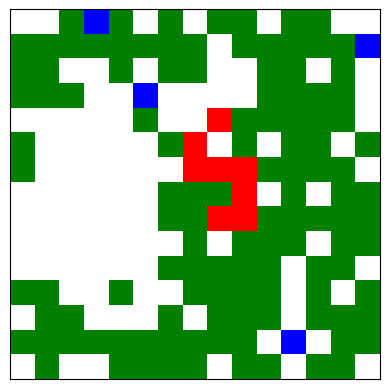

Fire Percentage: 3.5555555555555554
Forest Coverage: 52.888888888888886
Time step: 44


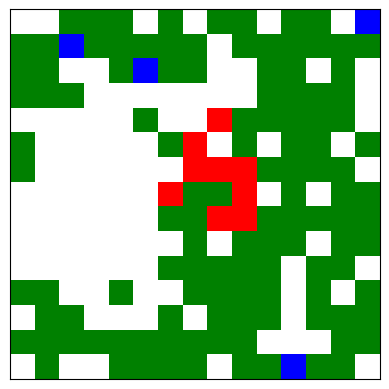

Fire Percentage: 4.0
Forest Coverage: 52.44444444444445
Time step: 45


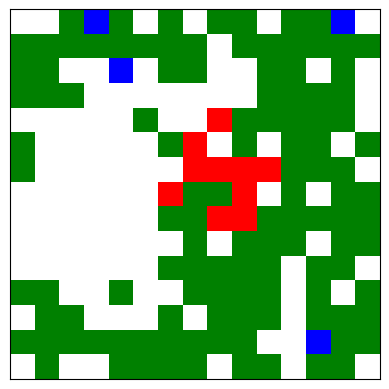

Fire Percentage: 4.444444444444445
Forest Coverage: 52.0
Time step: 46


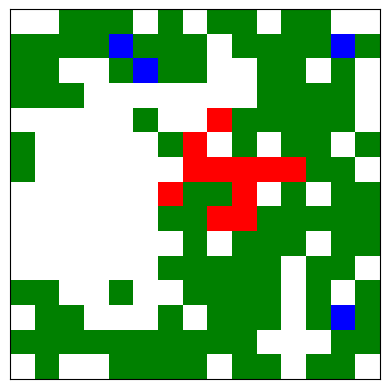

Fire Percentage: 4.888888888888889
Forest Coverage: 51.55555555555556
Time step: 47


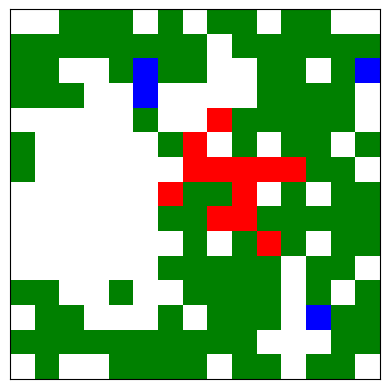

Fire Percentage: 5.333333333333334
Forest Coverage: 51.11111111111111
Time step: 48


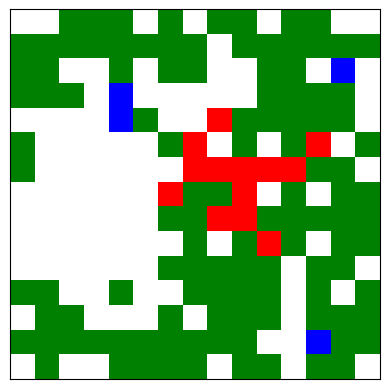

Fire Percentage: 5.777777777777778
Forest Coverage: 50.66666666666667
Time step: 49


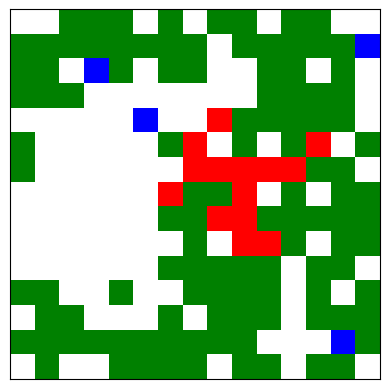

Fire Percentage: 6.222222222222222
Forest Coverage: 50.22222222222222
Time step: 50


In [112]:
for i in range(50):
    example.step()
    example.draw()
    print("Fire Percentage: " + str(example.fire_percentage()))
    print("Forest Coverage: " + str(example.forest_percentage()))
    print("Time step: "+str(i+1))


We will visualise the plot to evaluate the forest coverage and number of fire spreads through the time

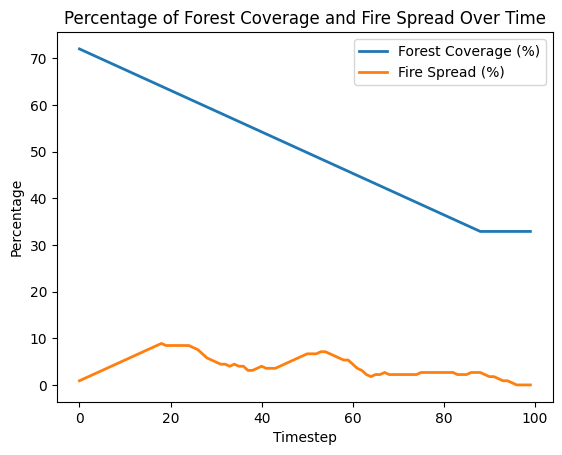

In [113]:
np.random.seed(17)
simulation = Forest(15,0.75, 20)
fire_percentages = []
forest_percentages = []

for i in range(100):
    simulation.step()
    fire_percentages.append(simulation.fire_percentage())
    forest_percentages.append(simulation.forest_percentage())

plt.plot(forest_percentages, label='Forest Coverage (%)')
plt.plot(fire_percentages, label='Fire Spread (%)')
plt.xlabel('Timestep')
plt.ylabel('Percentage')
plt.title('Percentage of Forest Coverage and Fire Spread Over Time')
plt.legend()
plt.show()

We will put all the code above to the function, so we can re-use it

In [114]:
def evaluation_plot(model,timestep):
    simulation = model
    # store the list of values
    fire_percentages = []
    forest_percentages = []

    for i in range(timestep) :
        simulation.step()
        fire_percentages.append(simulation.fire_percentage())
        forest_percentages.append(simulation.forest_percentage())

    plt.plot(forest_percentages, label='Forest Coverage (%)')
    plt.plot(fire_percentages, label='Fire Spread (%)')
    plt.xlabel('Timestep')
    plt.ylabel('Forest Coverage (%)')
    plt.title('Percentage of Forest Coverage and Fire Spread Over Time')
    plt.legend()
    plt.show()

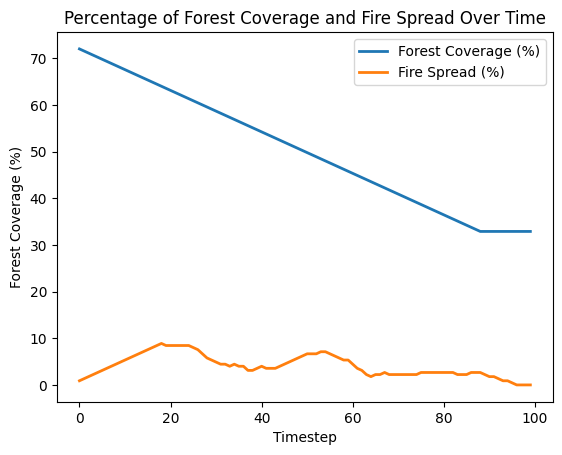

In [115]:
np.random.seed(17)
evaluation_plot(Forest(15, 0.75, 20),100)

Now, we will make the the modelling process being more complex. In the new models, the fire fighters can communicate with each other. Therefore, when a fire fighter spots a fire, they will share the fire locations with other fire fighters, so they can move one step closer to extinguish them. With this implimentation, it could be expected that the fire extinguish time will be faster. For this new complex rule, then the class will be changed to Forest_complex and Fire_fighter_complex

In [116]:
class Forest_complex(Cell2D):
    """Represents a grid of forest and fire agent."""

    options = dict(mode='same', boundary='wrap') #Same size, the neighbors are wrapped around the edges (cell)

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8) # Mention the 3*3 array, with 8 neighbors and center is the current cell which will not be counted

    def __init__(self, n, p, fire_life_time):
        """Initializes the forest attributes.

        n: number of rows -- size of the environment
        p: threshold on the fraction of empty and trees coverage area
        """
        # Forest area
        self.forest_area = n*n # the map (area) of the fire
        self.fire_life_time = fire_life_time # the life time of the fire

        self.fire_life = np.zeros((n,n), dtype=np.int8) # The array to store the age of the fire

        # A list of fire fighters
        self.fire_fighters=[]

        # 0 is neither no tree and fire, 1 is agent labelled as tree, 2 is agent labelled with fire
        states = np.array([0, 1], dtype=np.int8)
        probability = [1-p, p]

        self.kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8) # Mention the 3*3 array, with 8 neighbors and center is the current cell which will not be counted

        # Randomly initialize a forest grid with size n*n, occupied by two kinds of agents (empty and tree)
        # About 25% of the forest are empty.
        # In [0, 1], 25% of the forest will be empty, 75% of the forest will be filled with 1 (which means with trees).
        self.forest = np.random.choice(states, (n, n), p=probability)

        # Create the fire fighters:
        self.forest, self.fire_fighters = self.create_fire_fighters(n)

        # Create the fire
        self.forest, self.fire = self.create_fire()

        self.tree_replaced=0 # Save the state to swap the location of when the fire fighters move
        self.firefighter_spot = None # Check whether the first fire spotted

    def create_fire_fighters(self,n):
        """Initializes the fire fighters in 4 corners of the forest. The state of the fire fighters will be 3"""
        initial_locations = [(0,0), (0,n-1), (n-1,0), (n-1,n-1)] # 4 corners of the map
        for location in initial_locations:
            self.forest[location[0],location[1]] = 3
            self.fire_fighters.append(Fire_fighter_complex(location)) # Create the fire fighters with new class of Fire_fighter_complex
        return self.forest, self.fire_fighters

    def create_fire(self):
        """Initializes the a fire. The state of the fire will be 2"""
        tree_locations = np.argwhere(self.forest==1) # Check where the trees' locations in the forest
        random_fire = tree_locations[np.random.choice(len(tree_locations))] # Choose random one tree location which will have the fire
        self.forest[random_fire[0], random_fire[1]]=2 # Change the state of the tree to 3 which means the tree is being burned
        return self.forest, random_fire

    def ignite_trees(self):
        """Change the states of the trees to being burned if there is a fire surrounding them"""
        mask = self.forest == 2 # Create the mask to check the fire locations

        self.fire_life[mask]+= 1 # Add the life of the fire

        firing =np.argwhere(self.fire_life>=self.fire_life_time)
        for fire in firing:
            self.forest[fire[0], fire[1]]=0 # When the fire burned the fire
            self.fire_life[fire[0], fire[1]]=0 # Change the state of the fire after aged to 0

        surrounding_trees = correlate2d(mask, self.kernel, mode = 'same') # Check for the fire on the map
        being_burned = np.argwhere((self.forest==1) & (surrounding_trees > 0))
        if len(being_burned)>0: # If there are 1 tree, then that tree will be burned. If more than 2 trees, the fire will burn randomly one tree
            random_being_burned = being_burned[np.random.choice(len(being_burned))]
            self.forest[random_being_burned[0], random_being_burned[1]]=2
            self.fire_life[random_being_burned[0], random_being_burned[1]] = 1 # Set the age of the fire to 1

    def step(self):
      """Execute every timestep, with some adjustment"""
      self.ignite_trees()
      # Check if any firefighter spotted the firt fire
      for fire_fighter in self.fire_fighters:
          if fire_fighter.check(self.forest):
              self.firefighter_spot = fire_fighter.loc # store the fire fighter location to other fire fighters to move toward the target location

      # Move firefighters
      for fire_fighter in self.fire_fighters:
          if fire_fighter.loc == self.firefighter_spot: # Whether the fire fighter is the first person who spotted the first fire. This will be used once only
              fire_fighter.extinguish_fire(self.forest) # Let the fire fighter extinguish the fire
          else:
              # If this is not the fire fighter who spotted the first fire, then they will closer to the firefighter spot. Every timestep after that, all the fire fighters will use this move
              fire_fighter.move_closer(self.forest, self.firefighter_spot)

          self.tree_replaced += fire_fighter.previous_state # Replace the cell that the fire fighters standed on to its previous stage

    def fire_percentage(self):
        """Calculate the percentage of fire spread over each timestep"""
        return (np.sum(self.forest==2) / self.forest_area)*100

    def forest_percentage(self):
        """Calculate the percentage of forest coverage over each timestep"""
        forest_coverage = ((np.sum(self.forest==1) + self.tree_replaced) / self.forest_area)*100
        self.tree_replaced=0
        return forest_coverage

    def draw(self):
        """Draws the forest grid with the specified colors for each cell state"""
        cmap = ListedColormap(['white', 'green', 'red', 'blue'])  # Color map for states
        plt.imshow(self.forest, cmap=cmap, origin='lower')
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        plt.show()


In [117]:
class Fire_fighter_complex:
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8) #mention the 3*3 array, with 8 neighbors and center is the current cell which will not be counted

    def __init__(self, loc):
        self.loc=loc # save the location of the fire fighter
        self.previous_state = 0 # save the previous stage where they standed

    def check(self, forest):
        """Check the surroundings of the fire fighter to see if there is any fire
        Return a list of the fire locations
        """
        # Create the fire locations list
        fires = []
        # Ctore the shape of the forest
        n = forest.shape[0]
        # The location of the fire fighter in the map
        x, y = self.loc
        # There are 8 possible directions the fire fighter can move. As in this case, the fire fighter can only move one cell per timestep
        ways = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        for loc_x, loc_y in ways:
            # Calculate the surrounding location
            new_x = (x+loc_x)
            new_y = (y+loc_y)
            # Check if the location next to the fire fighter is the fire or not
            if 0 <= new_x < n and 0 <= new_y < n:
              if forest[new_x, new_y] == 2:
                  fires.append((new_x, new_y)) #location of the fire on the forest
        return fires # Return the list of fire location

    def extinguish_fire(self, forest):
        """Extinguish a fire if there is at least one fire surrounding the fire fighter. Move randomly otherwise"""
        fires = self.check(forest)
        if len(fires) == 0: #if there is no fire surrounding the fire fighter, then just move randomly
            self.move(forest)
        else:
            #select randomly a fire to move toward
            fire_loc = fires[np.random.choice(len(fires))]
            x, y = self.loc
            #bring back the state of the cell where the fire fighter was on
            forest[x,y] = self.previous_state
            #save the fire fighter new location as the fire location
            self.loc = fire_loc
            # The fire location will be occupied by the fire fighter, so the state will be changed
            forest[fire_loc]=3
            # When the fire fighter move away from the fire, the cell will be empty
            self.previous_state = 0

    def move(self, forest):
        """Move the fire fighter"""
        # The shape of the forest
        n = forest.shape[0]
        # The location of the fire fighter in the map
        x, y = self.loc
        # There are 8 possible directions the fire fighter can move. As in this case, the fire fighter can only move one cell per timestep
        ways = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
        # Shuffle directions to add randomness
        np.random.shuffle(ways)
        # Attempt to move in one randomly chosen valid direction
        for new_loc_x, new_loc_y in ways:
            # Calculate the new location of the fire fighter
            new_x = x+new_loc_x
            new_y = y+new_loc_y
            if 0<=new_x<n and 0<=new_y<n:
                if forest[new_x, new_y] in (0,1):
                    #save the state of the cell before changing
                    new_cell_state = forest[new_x, new_y]
                    #set the previous location of the fire fighter to the previous state of that location (either empty or a tree)
                    forest[x,y] = self.previous_state
                    #set the new location the fire fighter move to to fire fighter
                    forest[new_x, new_y]=3
                    #save the state of the cell that the fire fighter move to to the previous state, so either empty or tree locations will be saved
                    self.previous_state = new_cell_state
                    self.loc = (new_x, new_y)
                    return
        # If no valid move, do nothing
        forest[x, y] = 3

    def find_all_fires(self, forest):
        """Find all fire locations in the entire forest."""
        # Once a fire fighter spotted a fire, then they will share all the fire locations to other fire fighters
        fire_locations = np.argwhere(forest == 2)  # Find all cells where fire exists (state = 2)
        return fire_locations

    def move_closer(self, forest, target_loc):
        """Move the fire fighter one step closer to the fire closest to that fire fighter"""
        # If there is no fire, then the fire fighter will move randomly
        if not target_loc:
            self.move(forest)  # If there is no fire target, then just move move randomly
            return

        fires = self.check(forest) # The fire fighter check the surroundings
        if len(fires) > 0: # If there is at least one fire, then the fire fighter will move to fire to extinguish it
            self.extinguish_fire(forest)
            return

        # Calculate the smallest distance to the fire
        fire_locations = self.find_all_fires(forest)
        if len(fire_locations) > 0:
            # Find the nearest fire location to move toward
            nearest_fire_loc = min(fire_locations, key=lambda loc: abs(loc[0] - self.loc[0]) + abs(loc[1] - self.loc[1]))  # Calculate the Manhattan distance
            target_loc = nearest_fire_loc  # Set the target location to the nearest fire location
        else:
            target_loc = None  # No fires remained

        # And the fire fighter can move one step towards the fire
        if target_loc is not None: # If there
          n = forest.shape[0]
          x, y = self.loc
          target_x, target_y = target_loc
          best_move = None
          best_distance = float('inf')

          # Directions for potential movement
          ways = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

          for new_loc_x, new_loc_y in ways:
              new_x = x + new_loc_x
              new_y = y + new_loc_y
              if 0 <= new_x < n and 0 <= new_y < n:
                  if forest[new_x, new_y] in (0, 1):
                      distance = abs(new_x - target_x) + abs(new_y - target_y)  # Calculate the Manhattan distance
                      if distance < best_distance:
                          best_distance = distance
                          best_move = (new_x, new_y)

          if best_move: #if the fire fighter have the best move they can go, then they move towards it
              forest[x, y] = self.previous_state
              new_x, new_y = best_move
              self.previous_state = forest[new_x, new_y]
              forest[new_x, new_y] = 3
              self.loc = best_move
        else:
          # No fires, just move randomly
          self.move(forest)

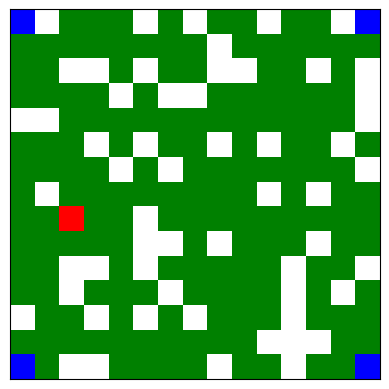

Fire Percentage: 0.4444444444444444
Forest Coverage: 72.44444444444444
Time step: 0


In [118]:
np.random.seed(17)
example1 = Forest_complex(15, 0.75, 20)
example1.draw()
print("Fire Percentage: " + str(example1.fire_percentage()))
print("Forest Coverage: " + str(example1.forest_percentage()))
print("Time step: "+str(0))

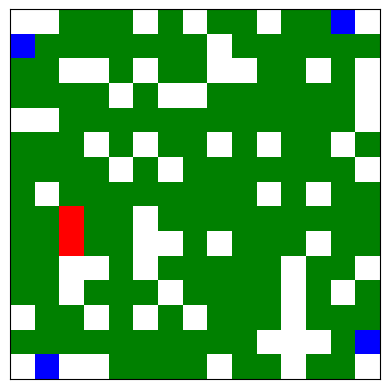

Fire Percentage: 0.8888888888888888
Forest Coverage: 72.0
Time step: 1


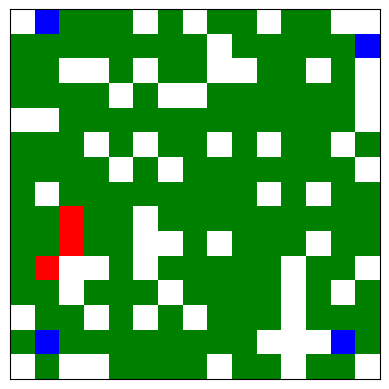

Fire Percentage: 1.3333333333333335
Forest Coverage: 71.55555555555554
Time step: 2


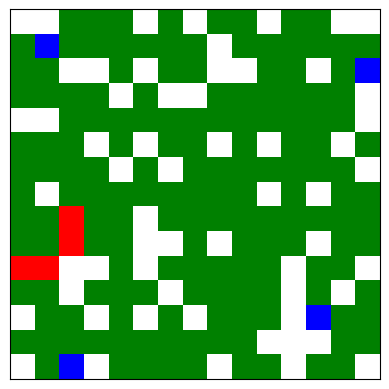

Fire Percentage: 1.7777777777777777
Forest Coverage: 71.11111111111111
Time step: 3


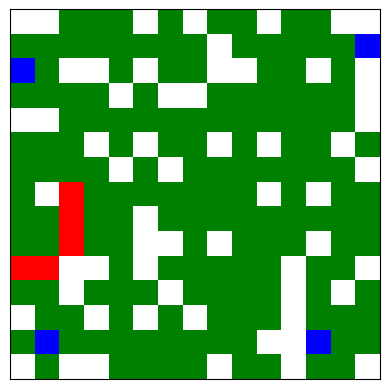

Fire Percentage: 2.2222222222222223
Forest Coverage: 70.66666666666667
Time step: 4


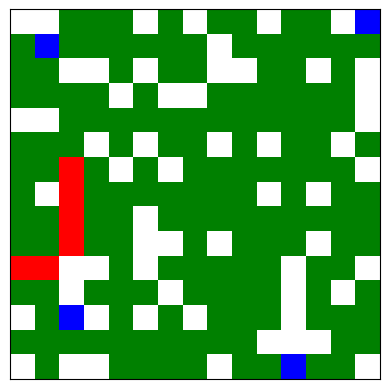

Fire Percentage: 2.666666666666667
Forest Coverage: 70.22222222222221
Time step: 5


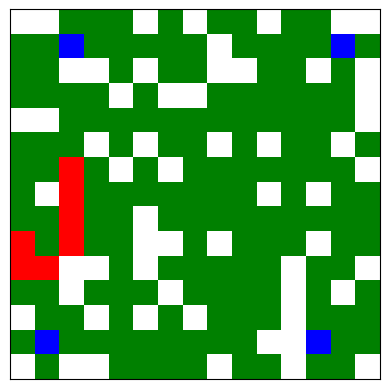

Fire Percentage: 3.111111111111111
Forest Coverage: 69.77777777777779
Time step: 6


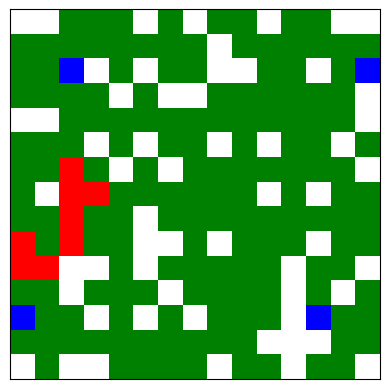

Fire Percentage: 3.5555555555555554
Forest Coverage: 69.33333333333334
Time step: 7


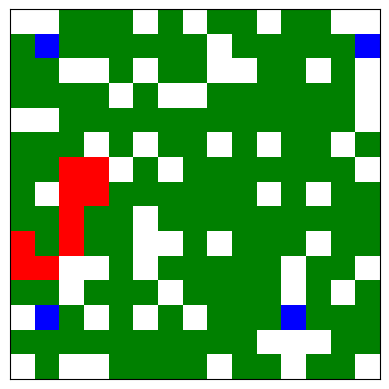

Fire Percentage: 4.0
Forest Coverage: 68.88888888888889
Time step: 8


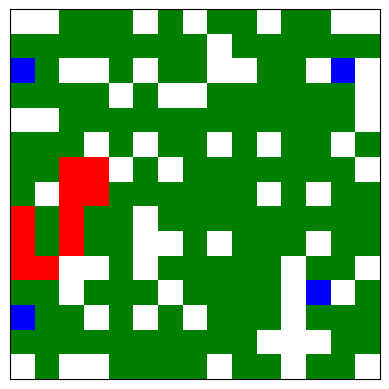

Fire Percentage: 4.444444444444445
Forest Coverage: 68.44444444444444
Time step: 9


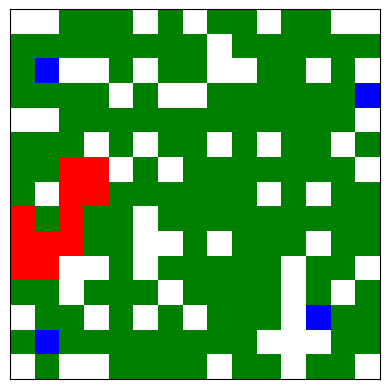

Fire Percentage: 4.888888888888889
Forest Coverage: 68.0
Time step: 10


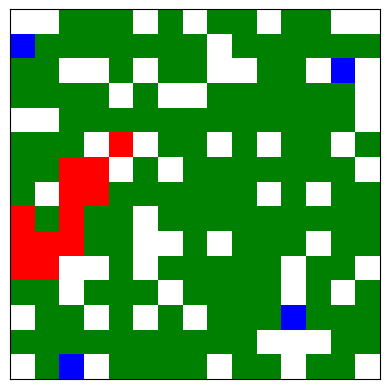

Fire Percentage: 5.333333333333334
Forest Coverage: 67.55555555555556
Time step: 11


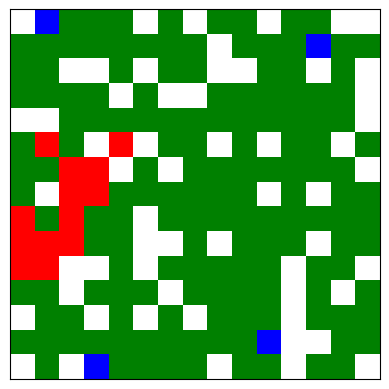

Fire Percentage: 5.777777777777778
Forest Coverage: 67.11111111111111
Time step: 12


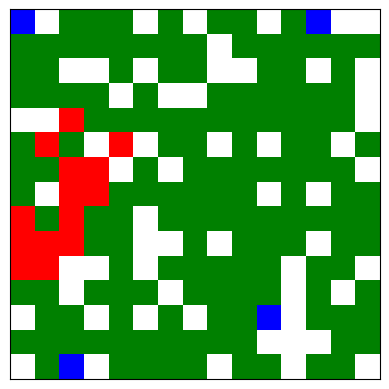

Fire Percentage: 6.222222222222222
Forest Coverage: 66.66666666666666
Time step: 13


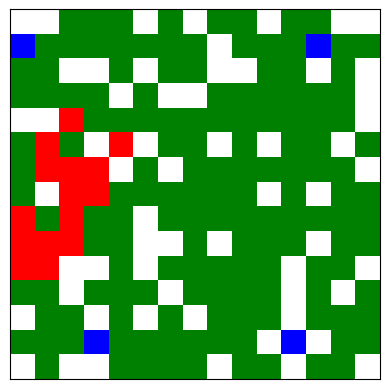

Fire Percentage: 6.666666666666667
Forest Coverage: 66.22222222222223
Time step: 14


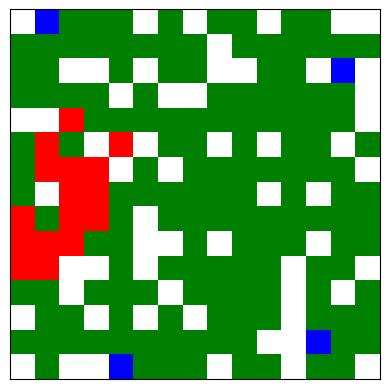

Fire Percentage: 7.111111111111111
Forest Coverage: 65.77777777777779
Time step: 15


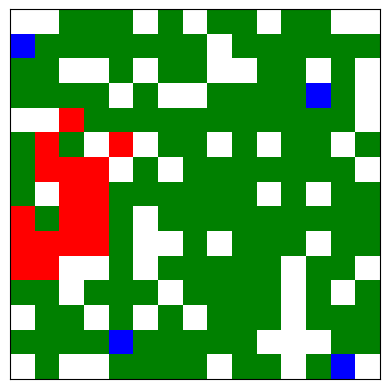

Fire Percentage: 7.555555555555555
Forest Coverage: 65.33333333333333
Time step: 16


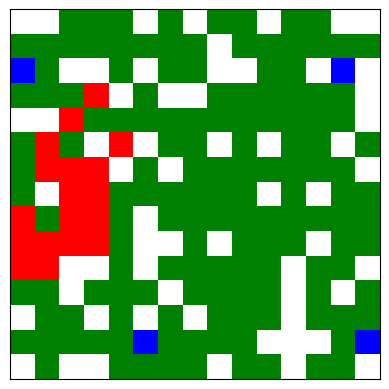

Fire Percentage: 8.0
Forest Coverage: 64.88888888888889
Time step: 17


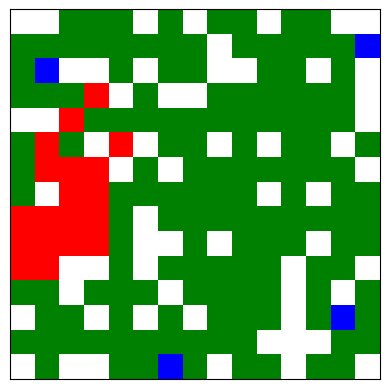

Fire Percentage: 8.444444444444445
Forest Coverage: 64.44444444444444
Time step: 18


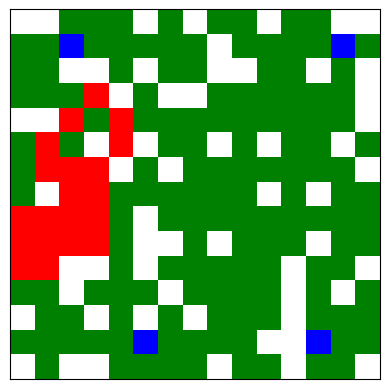

Fire Percentage: 8.88888888888889
Forest Coverage: 64.0
Time step: 19


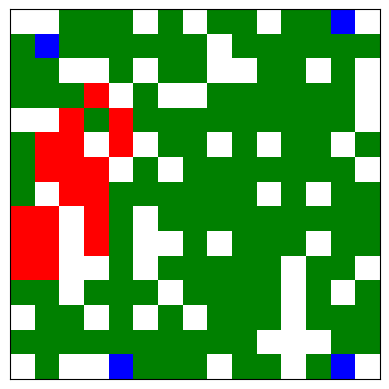

Fire Percentage: 8.444444444444445
Forest Coverage: 63.55555555555556
Time step: 20


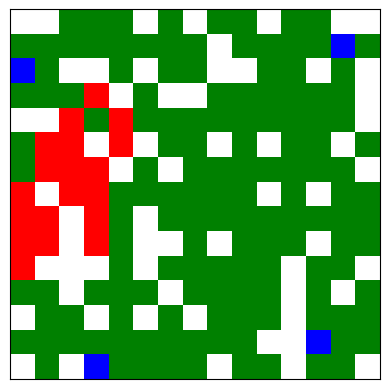

Fire Percentage: 8.444444444444445
Forest Coverage: 63.11111111111111
Time step: 21


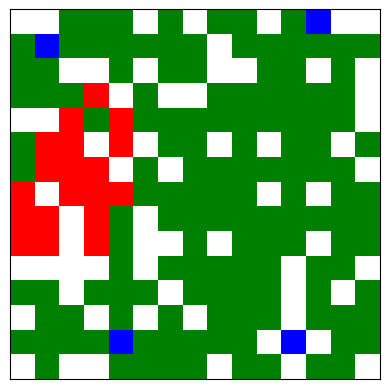

Fire Percentage: 8.444444444444445
Forest Coverage: 62.66666666666667
Time step: 22


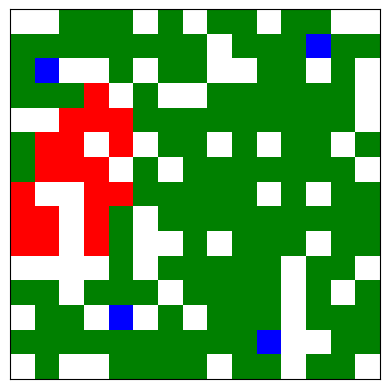

Fire Percentage: 8.444444444444445
Forest Coverage: 62.22222222222222
Time step: 23


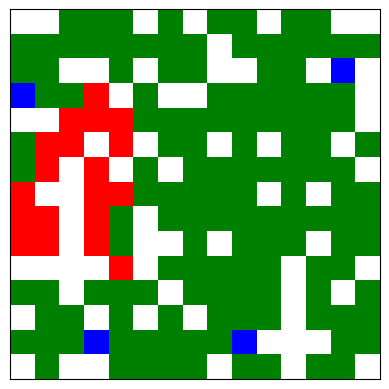

Fire Percentage: 8.444444444444445
Forest Coverage: 61.77777777777778
Time step: 24


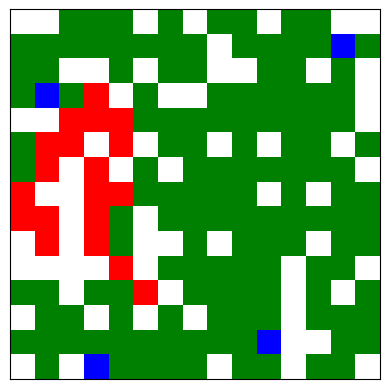

Fire Percentage: 8.444444444444445
Forest Coverage: 61.33333333333333
Time step: 25


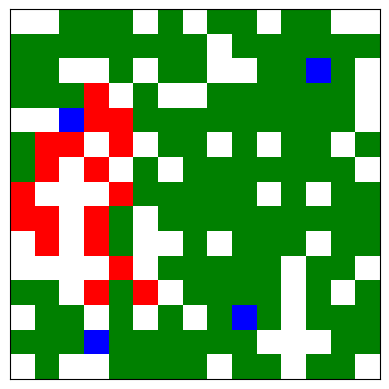

Fire Percentage: 8.0
Forest Coverage: 60.88888888888889
Time step: 26


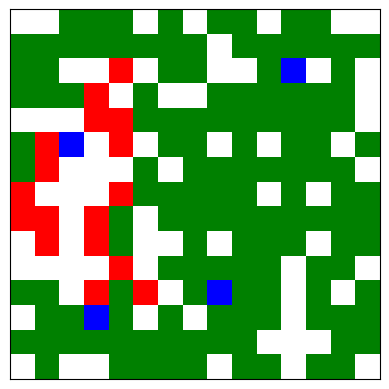

Fire Percentage: 7.555555555555555
Forest Coverage: 60.44444444444444
Time step: 27


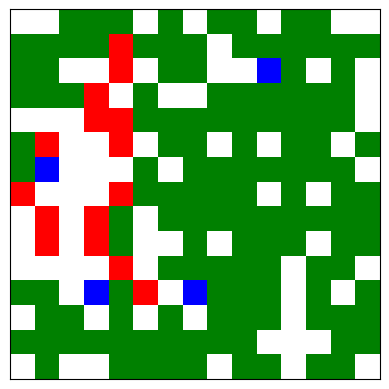

Fire Percentage: 6.666666666666667
Forest Coverage: 60.0
Time step: 28


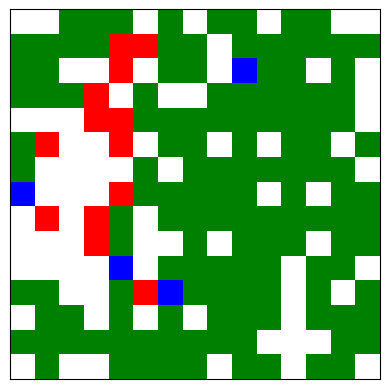

Fire Percentage: 5.777777777777778
Forest Coverage: 59.55555555555555
Time step: 29


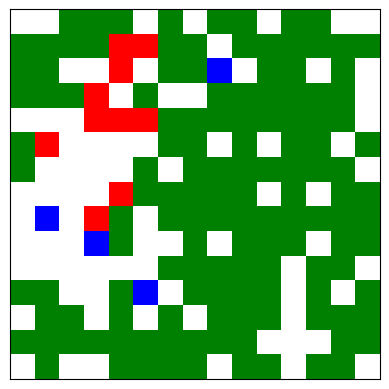

Fire Percentage: 4.444444444444445
Forest Coverage: 59.111111111111114
Time step: 30


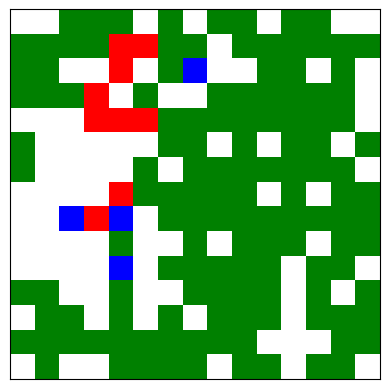

Fire Percentage: 4.0
Forest Coverage: 58.666666666666664
Time step: 31


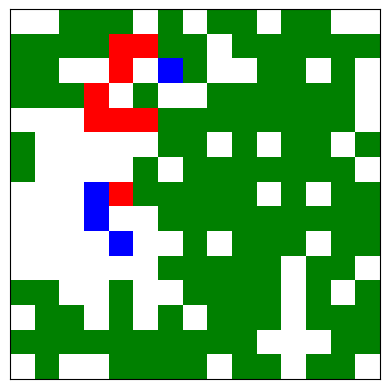

Fire Percentage: 3.5555555555555554
Forest Coverage: 58.22222222222222
Time step: 32


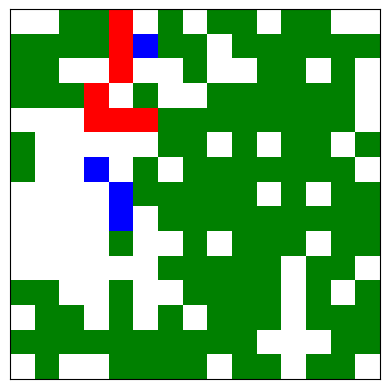

Fire Percentage: 3.111111111111111
Forest Coverage: 57.77777777777777
Time step: 33


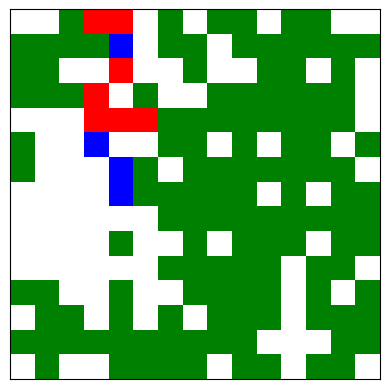

Fire Percentage: 3.111111111111111
Forest Coverage: 57.333333333333336
Time step: 34


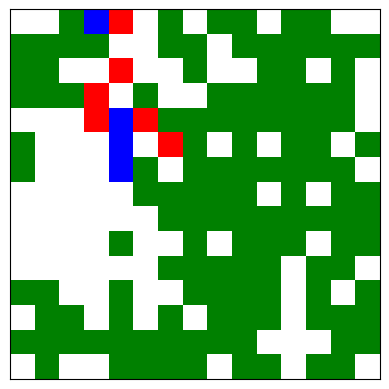

Fire Percentage: 2.666666666666667
Forest Coverage: 56.888888888888886
Time step: 35


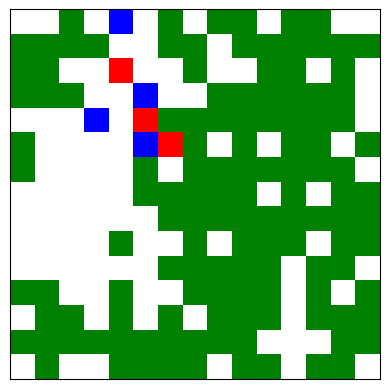

Fire Percentage: 1.3333333333333335
Forest Coverage: 56.44444444444444
Time step: 36


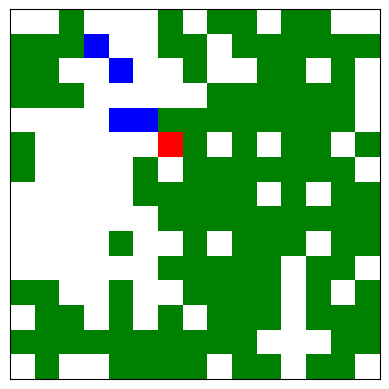

Fire Percentage: 0.4444444444444444
Forest Coverage: 56.00000000000001
Time step: 37


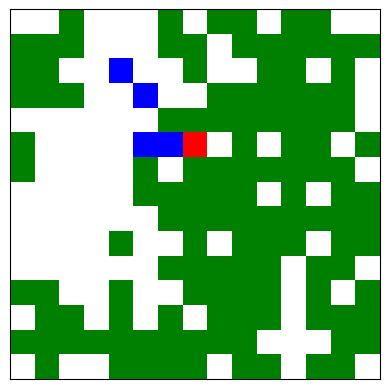

Fire Percentage: 0.4444444444444444
Forest Coverage: 55.55555555555556
Time step: 38


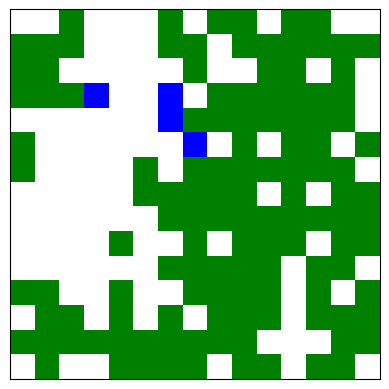

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 39


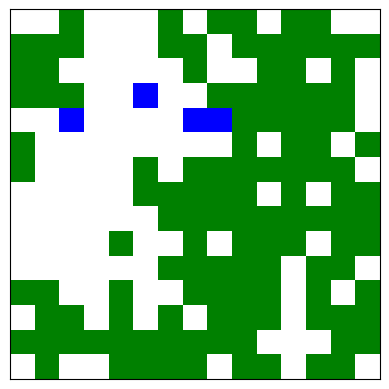

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 40


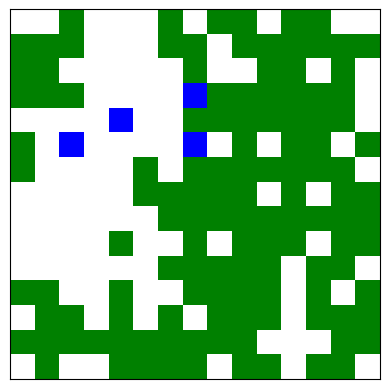

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 41


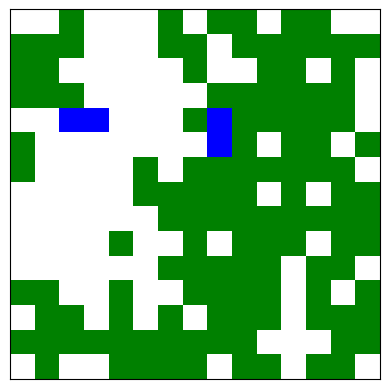

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 42


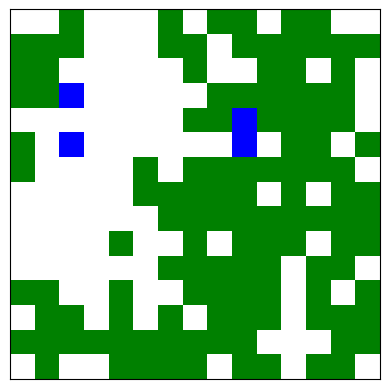

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 43


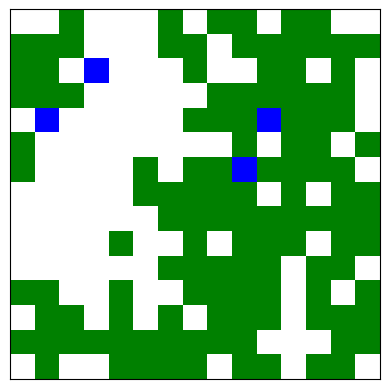

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 44


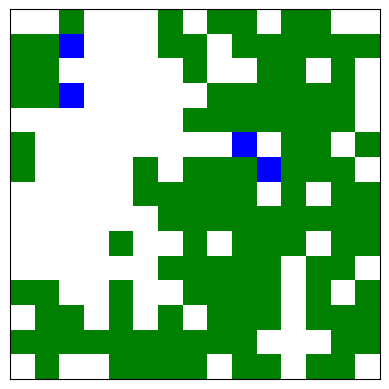

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 45


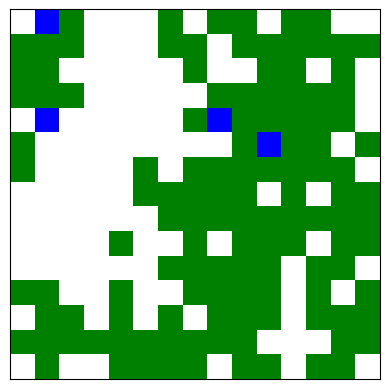

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 46


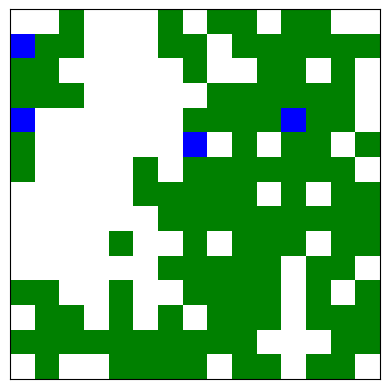

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 47


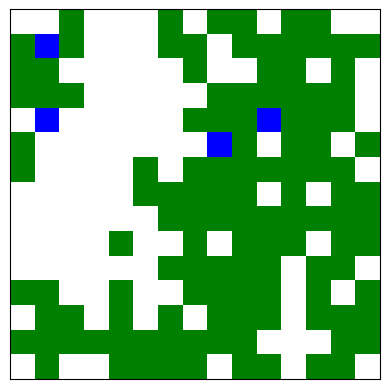

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 48


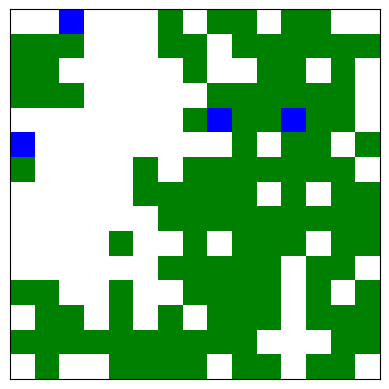

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 49


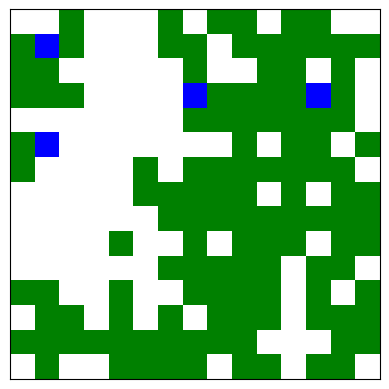

Fire Percentage: 0.0
Forest Coverage: 55.111111111111114
Time step: 50


In [119]:
for i in range(50):
    example1.step()
    example1.draw()
    print("Fire Percentage: " + str(example1.fire_percentage()))
    print("Forest Coverage: " + str(example1.forest_percentage()))
    print("Time step: "+str(i+1))

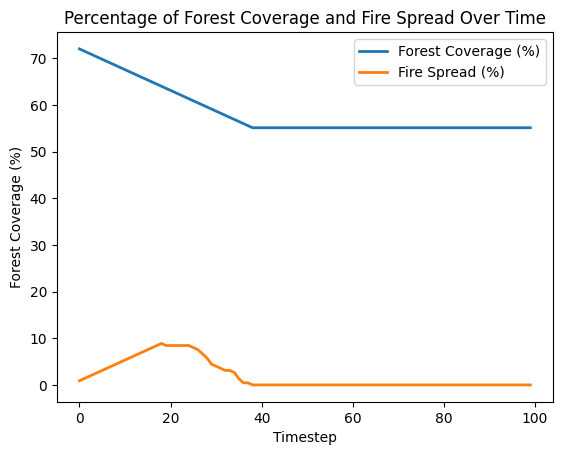

In [120]:
np.random.seed(17)
evaluation_plot(Forest_complex(15, 0.75, 20),100)

If we changed the life time of the fire 70


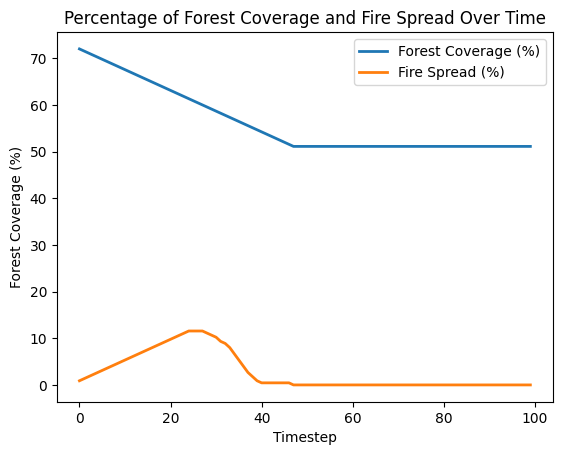

In [121]:
np.random.seed(17)
evaluation_plot(Forest_complex(15, 0.75, 70),100)

If we also change the size of the forest

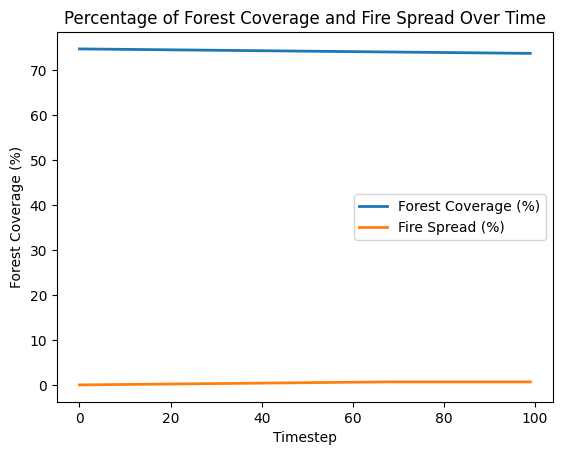

In [122]:
np.random.seed(17)
evaluation_plot(Forest_complex(100, 0.75, 70),100)